# Moving average trading

In [25]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import HBox, VBox, Label
from ipywidgets import interactive_output, jslink
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from ipywidgets import FloatText, IntText
from IPython.display import display

import trading as tra
import trading_plots as trp
import trading_defaults as dft

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Default parameters

In [26]:
TICKER     = 'AAPL'
REFRESH    = True # Download fresh Yahoo data 

START_DATE = '2020-07-17'
END_DATE   = datetime.strftime(datetime.now()- timedelta(days = 1), '%Y-%m-%d') #yesterday
print(END_DATE)

2021-03-25


### Data download

In [3]:
try:
    raw = tra.load_security(dirname = dft.DATA_DIR, 
                            ticker  = TICKER, 
                            refresh = REFRESH, 
                            period  = dft.DEFAULT_PERIOD,
                            )
except IndexError:
        print(f'Could not load {TICKER}')
except:
    print(f'Error type {sys.exc_info()[0]}')
else:
    security = pd.DataFrame(raw[f'Close_{TICKER}'])
    security.rename(columns={f'Close_{TICKER}': "Close"},
                    inplace=True)

    security

Loading ticker AAPL
[*********************100%***********************]  1 of 1 completed


#### Setup default start & end dates

In [4]:
# Check dates 
#print(tra.get_title_dates(security, START_DATE, END_DATE))
print(tra.get_datetime_date_range(security, START_DATE, END_DATE))
#print(tra.get_filename_dates(security, START_DATE, END_DATE))

[datetime.datetime(2020, 7, 17, 0, 0), datetime.datetime(2021, 3, 24, 0, 0)]


## Plotting functions

In [5]:
def plot_moving(span, date_range, fee_pct, buffer):
    trp.plot_moving(TICKER, date_range, security,span, fee_pct, buffer)

In [6]:
def plot_span_range(buffer, n_values, fee_pct, date_range):
    trp.plot_span_range(buffer     = buffer, 
                        n_values   = n_values, 
                        fee_pct    = fee_pct, 
                        date_range = date_range, 
                        ticker     = TICKER, 
                        security   = security, 
                       )

In [7]:
#### test driver for trp.plot_span_range
plot = False

if plot:
    plot_span_range(buffer     = .01, 
                    n_values   = 12, 
                    fee_pct    = FEE_PCT, 
                    date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                  datetime.strptime(END_DATE, '%Y-%m-%d')], 
                   )

In [8]:
def plot_buffer_range(span, n_values, fee_pct, date_range):
    trp.plot_buffer_range(span       = span, 
                          n_values   = n_values, 
                          fee_pct    = fee_pct, 
                          date_range = date_range, 
                          ticker     = TICKER, 
                          security   = security, 
                         )

In [9]:
#### test driver for trp.plot_span_range
plot = False
if plot:
    plot_buffer_range(span       = 20, 
                      n_values   = 12, 
                      fee_pct    = FEE_PCT, 
                      date_range = [datetime.strptime(START_DATE, '%Y-%m-%d'), 
                                    datetime.strptime(END_DATE, '%Y-%m-%d')], 
                     )

Outer Level / 56: 56it [01:05,  1.17s/it]



Max EMA 0=19.76%: 5-days buffer=1.17% (hold=25.30%)
Max EMA 1=19.76%: 6-days buffer=1.14% (hold=25.30%)
Max EMA 2=19.76%: 6-days buffer=1.17% (hold=25.30%)
Max EMA 3=19.73%: 5-days buffer=2.58% (hold=25.30%)
Max EMA 4=19.73%: 5-days buffer=2.61% (hold=25.30%)
Max EMA 5=19.73%: 5-days buffer=2.64% (hold=25.30%)
Max EMA 6=19.73%: 5-days buffer=2.67% (hold=25.30%)
Max EMA 7=19.73%: 5-days buffer=2.70% (hold=25.30%)
Max EMA 8=19.73%: 5-days buffer=2.73% (hold=25.30%)
Max EMA 9=19.73%: 5-days buffer=2.76% (hold=25.30%)


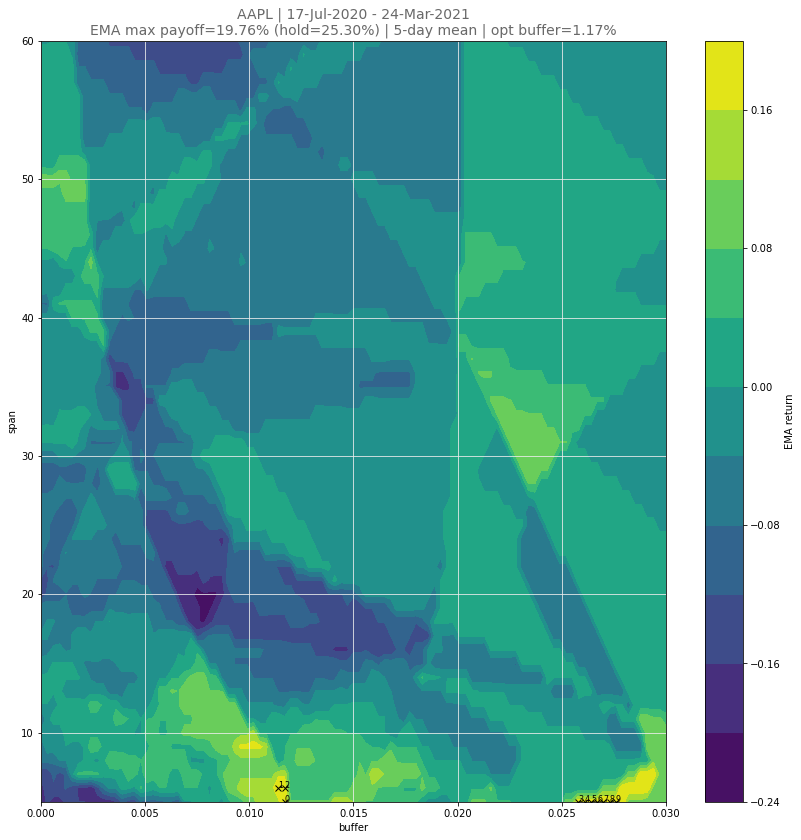

In [15]:
# Driver for plot_buffer_span_contours
plot = True
if plot:
    date_range = tra.get_datetime_date_range(security, START_DATE, END_DATE)
    spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, date_range)
    trp.plot_buffer_span_contours(TICKER, date_range, spans, buffers, emas, hold)

In [ ]:
x = []
for i, span in enumerate(spans): 
    for j, buffer in enumerate(buffers):
        x.append([span, buffer, emas[i,j]])
        
x = pd.DataFrame(x, columns=['span', 'buffer', 'ema'])

### Interactive plots

#### Widget defaults

In [ ]:
### Default parameter values
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = tra.get_datetime_dates(security, START_DATE, END_DATE)
dates        = pd.date_range(start_period, end_period, freq='D')
date_options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
date_index   = (0, len(date_options) - 1)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = dft.FEE_PCT

# of days for running mean
min_span     = dft.MIN_SPAN
max_span     = dft.MAX_SPAN
delta_span   = 1
default_span = 20

# buffer around EMA
min_buffer     = dft.MIN_BUFF
max_buffer     = dft.MAX_BUFF
delta_buffer   = .0001
default_buffer = .01

# number of maxima
max_value     = 15
default_value = 12

In [ ]:
## Widget methods

### Sliders
def get_span_slider():
    return IntSlider(min = min_span,
                     max=max_span,
                     step=delta_span,
                     value=default_span,
                     style=string_style,
                     disabled=False,
                     continuous_update=False,
                     readout=True,
                     readout_format='d',
                     layout = {'width': '250px'},
                    )

def get_buffer_slider():
    return FloatSlider(min=min_buffer,
                        max=max_buffer,
                        step=delta_buffer,
                        value=default_buffer,
                        style=string_style,
                        continuous_update=False,
                        disabled=False,
                        readout=True,
                        readout_format='.2%',
                        layout      = {'width': '250px'},
                       )
    
def get_fee_slider():
    return FloatSlider(min=min_fee,
                       max=max_fee,
                       step=delta_fee,
                       value=default_fee,
                       style=string_style,
                       disabled=False,
                       continuous_update=False,
                       readout=True,
                       readout_format='.2%',
                       layout      = {'width': '250px'},
                      )

def get_max_values_slider():
   return SelectionSlider(options=[x for x in range(0, max_value+1)],
                          value=default_value,
                          description='Number of maxima:',
                          style=string_style,
                          disabled=False,
                          continuous_update=False,
                          readout=True,
                          readout_format='d',
                          layout      = {'width': '500px'},
                          )
                       
def get_date_range_slider():
    return SelectionRangeSlider(options  = date_options,
                                 index   = date_index,
                                 description = 'Period:',
                                 orientation = 'horizontal',
                                 style       = string_style,
                                 layout      = {'width': '500px'}
                                )
### Text boxes
def get_fee_text_box():
    return FloatText(min=min_fee,
                     max=max_fee,
                     step=delta_fee,
                     value=default_fee,
                     description='Fees:',
                     style=string_style,
                     disabled=False,
                     readout_format='6.3%',
                     layout={'width': '150px'},
                    )
                       
def get_span_text_box():
    return IntText(min   = min_span,
                   max   = max_span,
                   step  = delta_span,
                   value = default_span,
                   style          = string_style,
                   disabled       = False,
                   description    = 'Span:',
                   readout_format = 'd',
                   layout={'width': '150px'},
                   )
                       
def get_buffer_text_box():
    return FloatText(min   = min_fee,
                     max   = max_fee,
                     step  = delta_fee,
                     value = default_fee,
                     style       = string_style,
                     disabled    = False,
                     description = 'Buffer:',
                     readout_format = '3%',
                     layout = {'width': '150px'},
                    )

#### Interactive returns for window span

In [ ]:
# Mean window span range optimizer interactive
buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

max_values_slider   = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

out = interactive_output(plot_span_range,
                         {'buffer'    : buffer_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                         }
                        )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_widgets,
                    bottom_right = max_values_slider,
                   )

display(ui, out)

#### Interactive returns for buffer size

In [ ]:
# Buffer range optimizer interactive 
span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

max_values_slider = get_max_values_slider()

fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

date_range_slider = get_date_range_slider()

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets = HBox([span_text_box, span_slider])

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

#### Interactive buffer-span

In [ ]:
# Buffer-span interactive plot
fee_slider   = get_fee_slider()
fee_text_box = get_fee_text_box()
fee_link     = jslink((fee_slider, 'value'), (fee_text_box, 'value'))

span_slider   = get_span_slider()
span_text_box = get_span_text_box()
span_link     = jslink((span_slider, 'value'), (span_text_box, 'value'))

buffer_slider   = get_buffer_slider()
buffer_text_box = get_buffer_text_box()
buffer_link     = jslink((buffer_slider, 'value'), (buffer_text_box, 'value'))

date_range_slider = get_date_range_slider()

out = interactive_output(plot_moving,
                         {'span'      : span_slider,
                          'buffer'    : buffer_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

fee_widgets    = HBox([fee_text_box, fee_slider])
span_widgets   = HBox([span_text_box, span_slider])
buffer_widgets = HBox([buffer_text_box, buffer_slider])

ui = TwoByTwoLayout(top_left     = fee_widgets,
                    top_right    = date_range_slider,
                    bottom_left  = span_widgets,
                    bottom_right = buffer_widgets,
                   )

display(ui, out)